In [2]:
import scanpy as sc
import os,sys,glob
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

In [3]:
sc.settings.n_jobs = 96
sc.set_figure_params(figsize=(5, 5), vector_friendly = True)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

# Load dataset

In [3]:
adata = sc.read("Data/ROSMAP2.h5ad") # 1574130 obs.

In [4]:
adata.obs.columns

Index(['batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'Library',
       'Hemisphere', 'PMI', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis',
       'cluster_original', 'cluster_main'],
      dtype='object')

# Scrublet

In [5]:
adata.obs["sampleID"].value_counts() # 437 patients.

R1028639    11474
R4817881    10450
R8724814     9812
R5693901     9051
R6679530     7373
            ...  
R5138383     1081
R1583702      863
R4022468      851
R5405023      712
R5026720        1
Name: sampleID, Length: 437, dtype: int64

In [6]:
adata = adata[adata.obs["sampleID"] != "R5026720"]

In [7]:
samples = adata.obs["sampleID"].unique()
samples # 436 patients.

['R9239503', 'R7651923', 'R8477425', 'R9764427', 'R5210462', ..., 'R4619330', 'R6268135', 'R6557859', 'R8971831', 'R3948425']
Length: 436
Categories (436, object): ['R9239503', 'R7651923', 'R8477425', 'R9764427', ..., 'R6268135', 'R6557859', 'R8971831', 'R3948425']

In [8]:
import scrublet as scr
import multiprocessing

def process_sample(sample):
    print(sample)
    adata1 = adata[adata.obs["sampleID"] == sample]

    # Doublet finding
    scrub = scr.Scrublet(adata1.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata1.obs['doublet_scores'] = doublet_scores
    adata1.obs['predicted_doublets'] = predicted_doublets    
    adata1.obs['predicted_doublets'] = adata1.obs['predicted_doublets'].astype(str)

    adata1 = adata1[adata1.obs['predicted_doublets'] == 'False']

    return adata1

In [ ]:
if __name__ == '__main__':
        num_processes = multiprocessing.cpu_count()
        pool = multiprocessing.Pool(processes=num_processes)

        with pool as p:
            list_data = p.map(process_sample, samples)

adata2 = ad.concat(list_data, join="outer") 

In [10]:
adata2.obs["predicted_doublets"].value_counts() # 1574130 -> 1567207 obs.

False    1567207
Name: predicted_doublets, dtype: int64

# Preprocessing

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3) 

In [12]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [14]:
adata = adata[adata.obs.n_genes_by_counts < 10000, :]
adata = adata[adata.obs.total_counts < 80000, :]
adata = adata[adata.obs.pct_counts_mt < 8, :]

In [15]:
adata # 1567207 -> 1560049 obs.

View of AnnData object with n_obs × n_vars = 1560049 × 35476
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'Library', 'Hemisphere', 'PMI', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'cluster_original', 'cluster_main', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Normalization

In [16]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy() 

In [17]:
adata

AnnData object with n_obs × n_vars = 1560049 × 35476
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'Library', 'Hemisphere', 'PMI', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'cluster_original', 'cluster_main', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts', 'logcounts'

In [18]:
adata.write_h5ad("Data/ROSMAP2_Rawdata.h5ad") 

# HVG scaling

In [3]:
adata = sc.read_h5ad("Data/ROSMAP2_Rawdata.h5ad")

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes = 5000,flavor="cell_ranger", batch_key='batch') # 15m

In [5]:
adata.raw = adata 

In [6]:
adata = adata[:, adata.var.highly_variable] 

In [ ]:
sc.pp.scale(adata, max_value=10) 

In [8]:
adata.layers["scaled"] = adata.X

In [9]:
adata

AnnData object with n_obs × n_vars = 1560049 × 5000
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'Library', 'Hemisphere', 'PMI', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'cluster_original', 'cluster_main', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'logcounts', 'scaled'

In [10]:
adata.write_h5ad("ROSMAP2_hgv_scaled.h5ad") 

# Principal component anlaysis

In [4]:
adata = sc.read_h5ad("Data/1106/ROSMAP2_hgv_scaled.h5ad")

In [5]:
sc.tl.pca(adata, svd_solver='arpack')

In [6]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) 

In [7]:
sc.tl.umap(adata) 

In [8]:
sc.tl.leiden(adata)

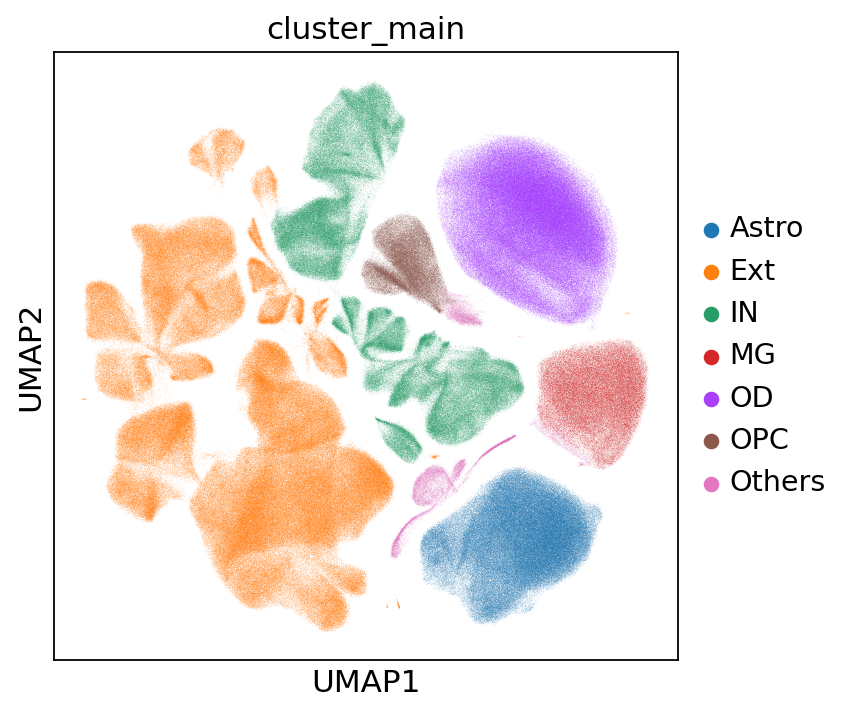

In [9]:
sc.pl.umap(adata,color=['cluster_main'])

# Harmony

In [10]:
# Convert batch labels to numeric variables
adata.obs['batch_numeric'] = adata.obs['batch'].cat.codes
adata.obs['sampleID_numeric'] = adata.obs['sampleID'].cat.codes

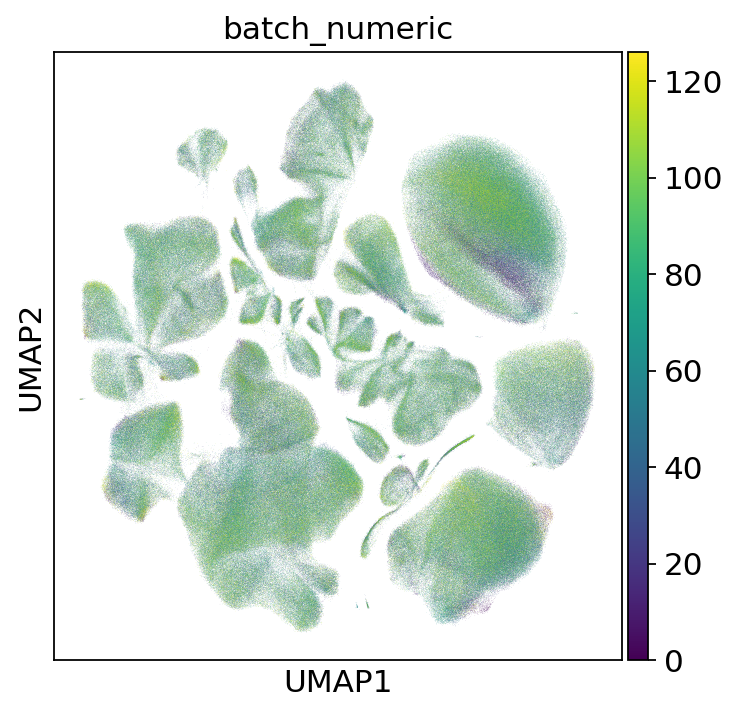

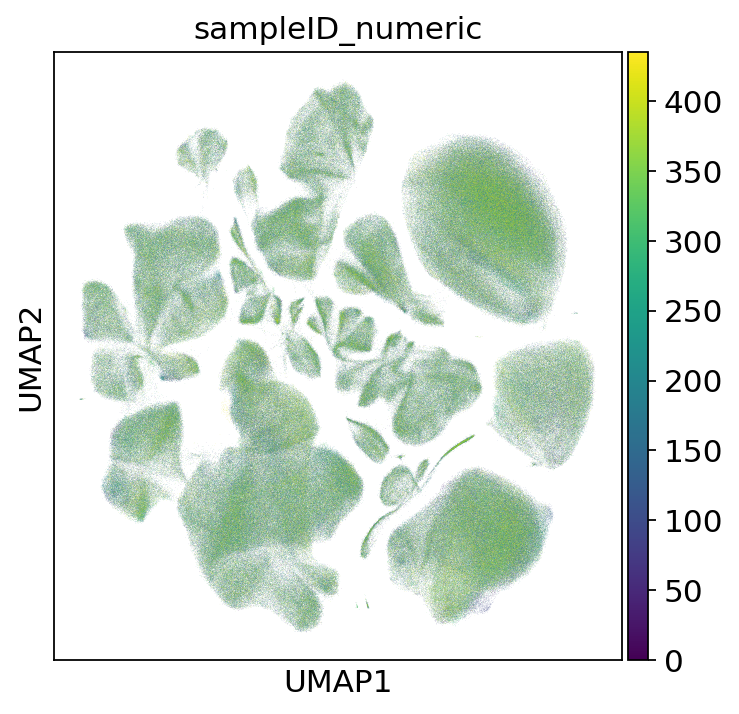

In [11]:
# Convert batch labels to numeric variables
sc.pl.umap(adata, color = "batch_numeric")
sc.pl.umap(adata, color = "sampleID_numeric")

In [12]:
sc.external.pp.harmony_integrate(adata, 'batch') 
#adata.obsm['X_pca'] = adata.obsm['X_pca_harmony'] 

2023-11-07 02:26:03,732 - harmonypy - INFO - Iteration 1 of 10
2023-11-07 02:55:54,100 - harmonypy - INFO - Iteration 2 of 10
2023-11-07 03:25:29,895 - harmonypy - INFO - Iteration 3 of 10
2023-11-07 03:54:50,503 - harmonypy - INFO - Iteration 4 of 10
2023-11-07 04:24:16,145 - harmonypy - INFO - Iteration 5 of 10
2023-11-07 04:38:22,134 - harmonypy - INFO - Iteration 6 of 10
2023-11-07 04:52:36,610 - harmonypy - INFO - Iteration 7 of 10
2023-11-07 05:06:39,726 - harmonypy - INFO - Iteration 8 of 10
2023-11-07 05:21:05,655 - harmonypy - INFO - Converged after 8 iterations


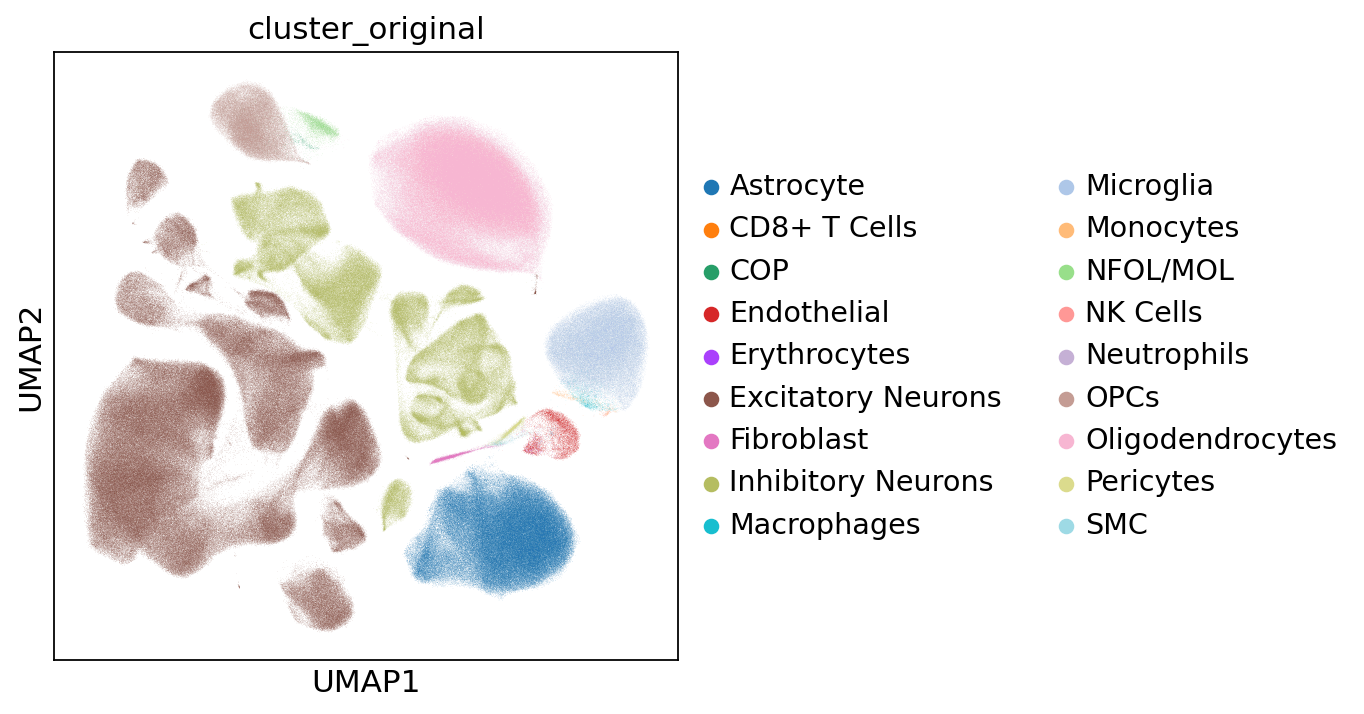

In [13]:
sc.pp.neighbors(adata, use_rep = 'X_pca_harmony')
sc.tl.umap(adata)
sc.pl.umap(adata, color = 'cluster_original') 

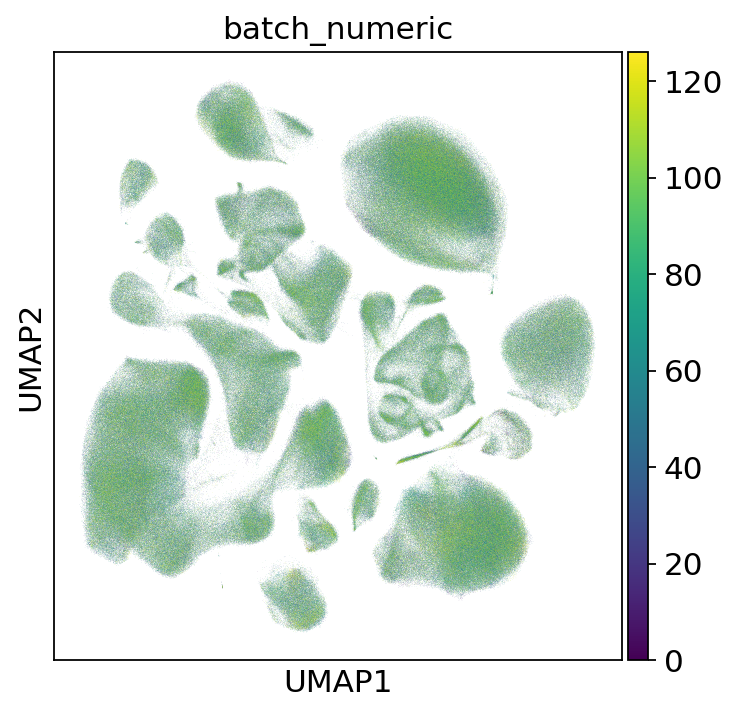

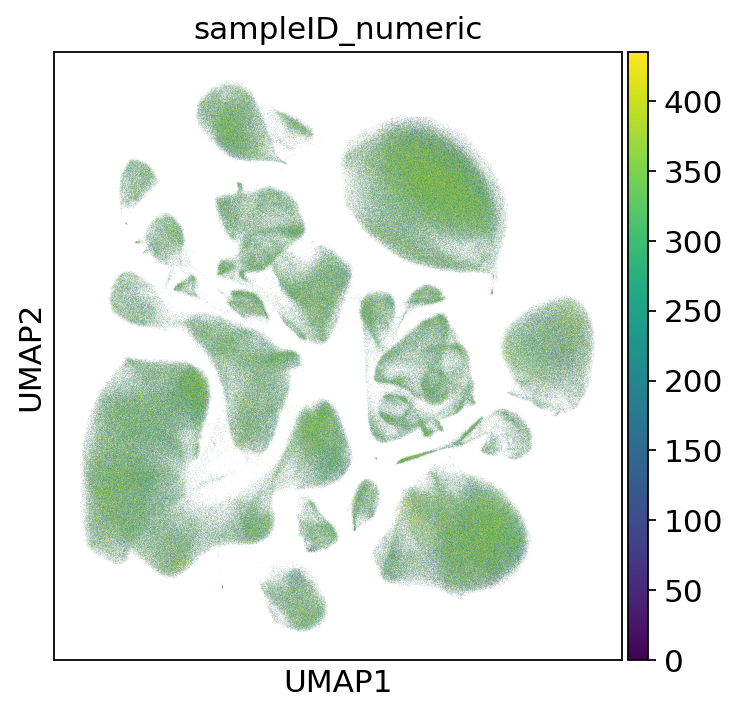

In [14]:
# Convert batch labels to numeric variables
sc.pl.umap(adata, color = "batch_numeric")
sc.pl.umap(adata, color = "sampleID_numeric")

In [15]:
adata.write_h5ad("ROSMAP2_Harmony.h5ad") 

# Cluster annotation

In [ ]:
adata = sc.read_h5ad("ROSMAP2_Harmony.h5ad")

In [17]:
adata

AnnData object with n_obs × n_vars = 1560049 × 5000
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'Library', 'Hemisphere', 'PMI', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'cluster_original', 'cluster_main', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'batch_numeric', 'sampleID_numeric'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'cluster_main_colors', 'cluster_original_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'counts', 'logcounts', 'scaled'
    obsp: 'distances', 'connectivities'

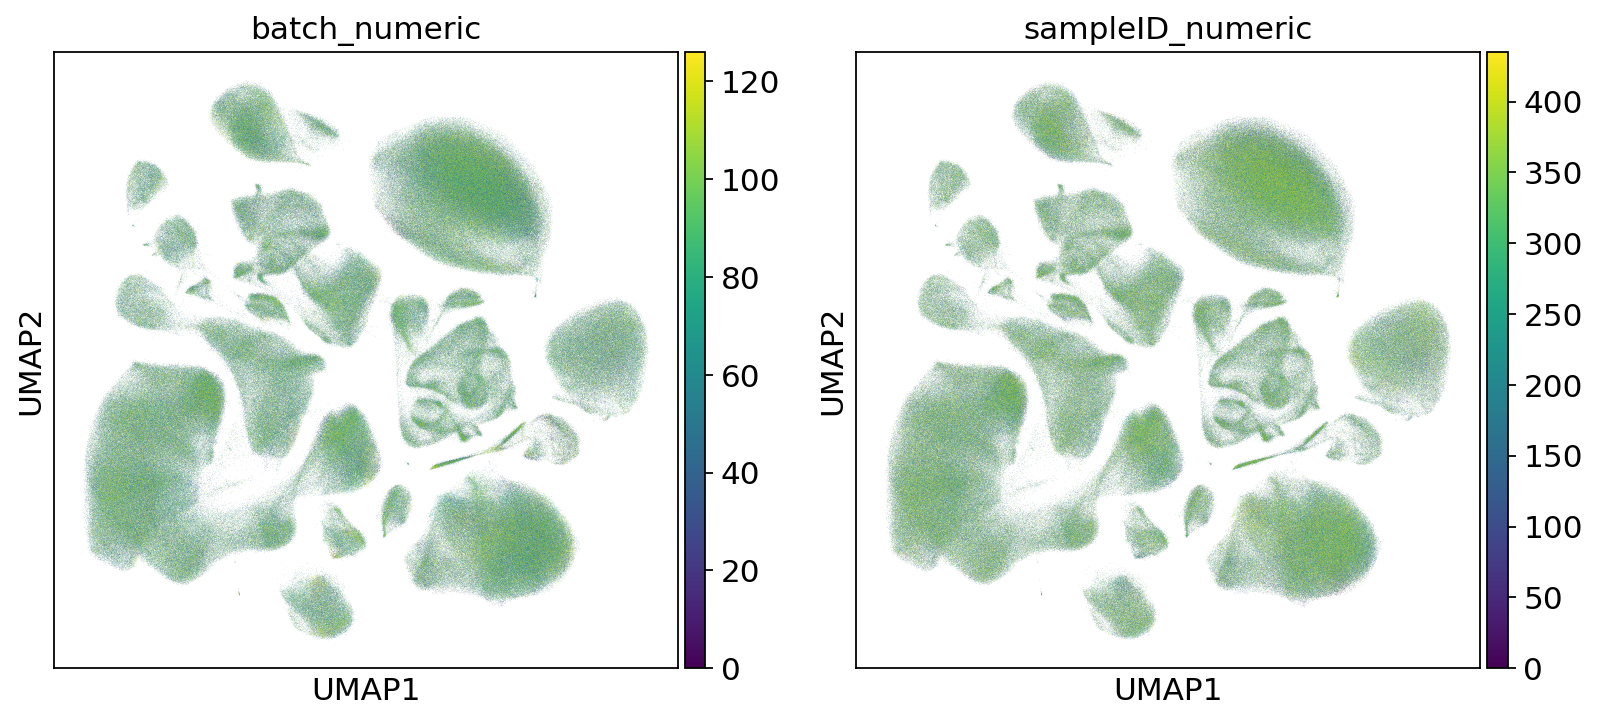

In [16]:
sc.pl.umap(adata, color = ["batch_numeric", "sampleID_numeric"])

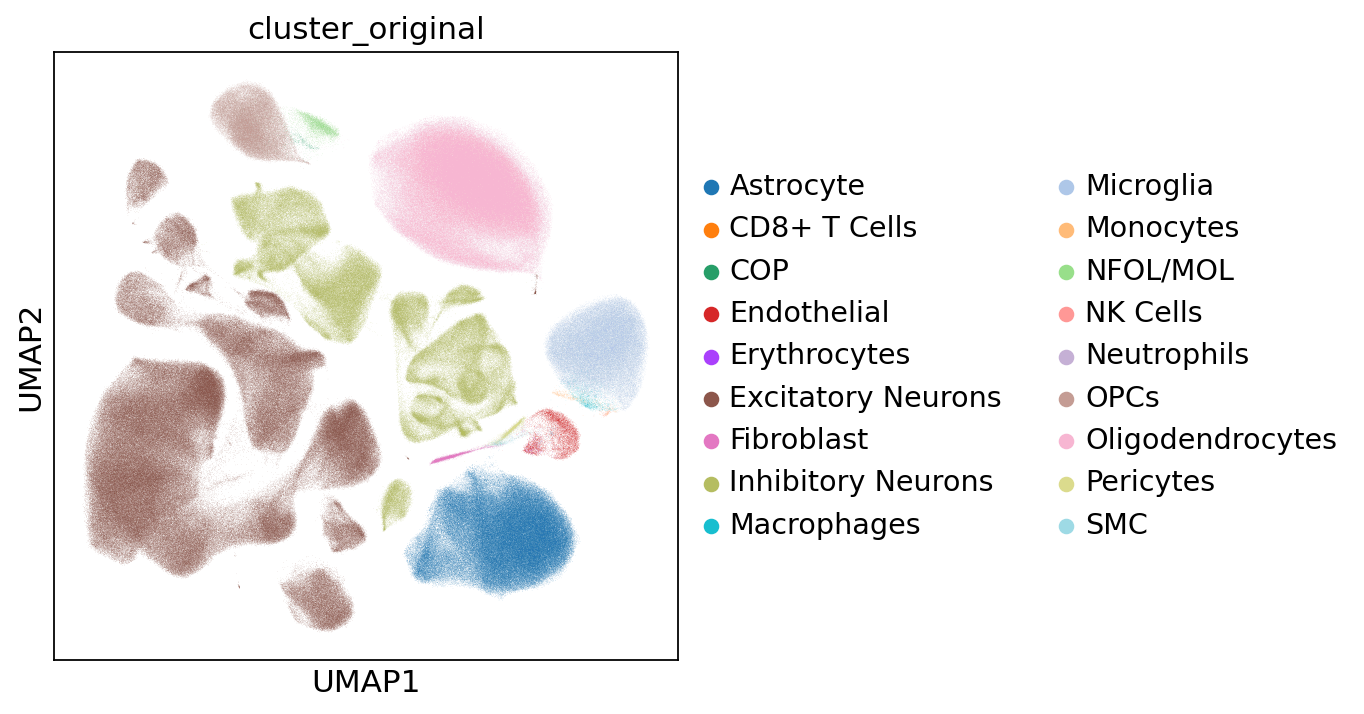

In [18]:
sc.pl.umap(adata, color = ["cluster_original"])

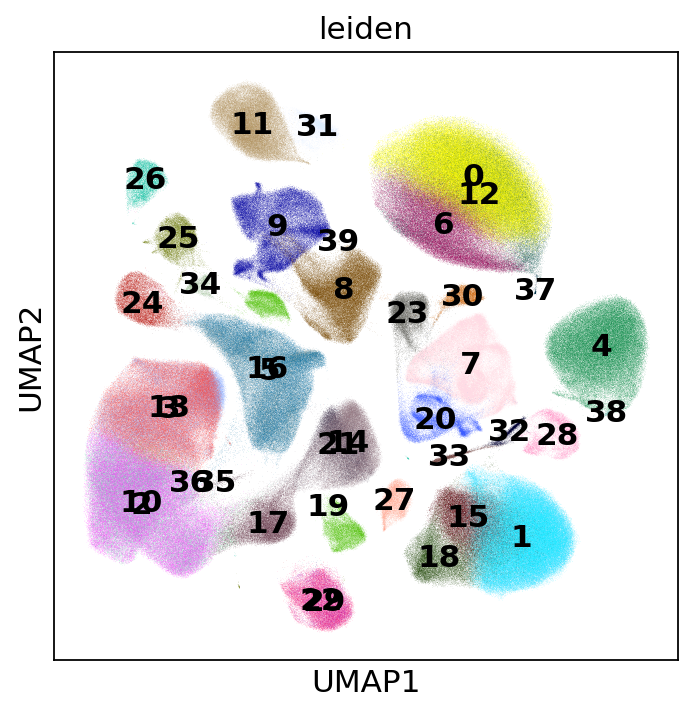

In [19]:
sc.pl.umap(adata, color = ["leiden"], legend_loc= "on data")

### Annotate clusters in Allen nomenclature

In [20]:
marker_genes_dict = {
	'Excitatory': ['SLC17A7', 'LINC00507', 'RORB', 'THEMIS', 'FEZF2'],
	'Inhibitory': ['GAD1', 'ADARB2', 'PAX6', 'LAMP5', 'VIP', 'LHX6', 'SST', 'PVALB'],
    'Non-neuronal': ['SLC1A3', 'PDGFRA', 'FGFR3', 'OPALIN', 'NOSTRIN', 'TYROBP'],
}

categories: 0, 1, 2, etc.
var_group_labels: Excitatory, Inhibitory, Non-neuronal


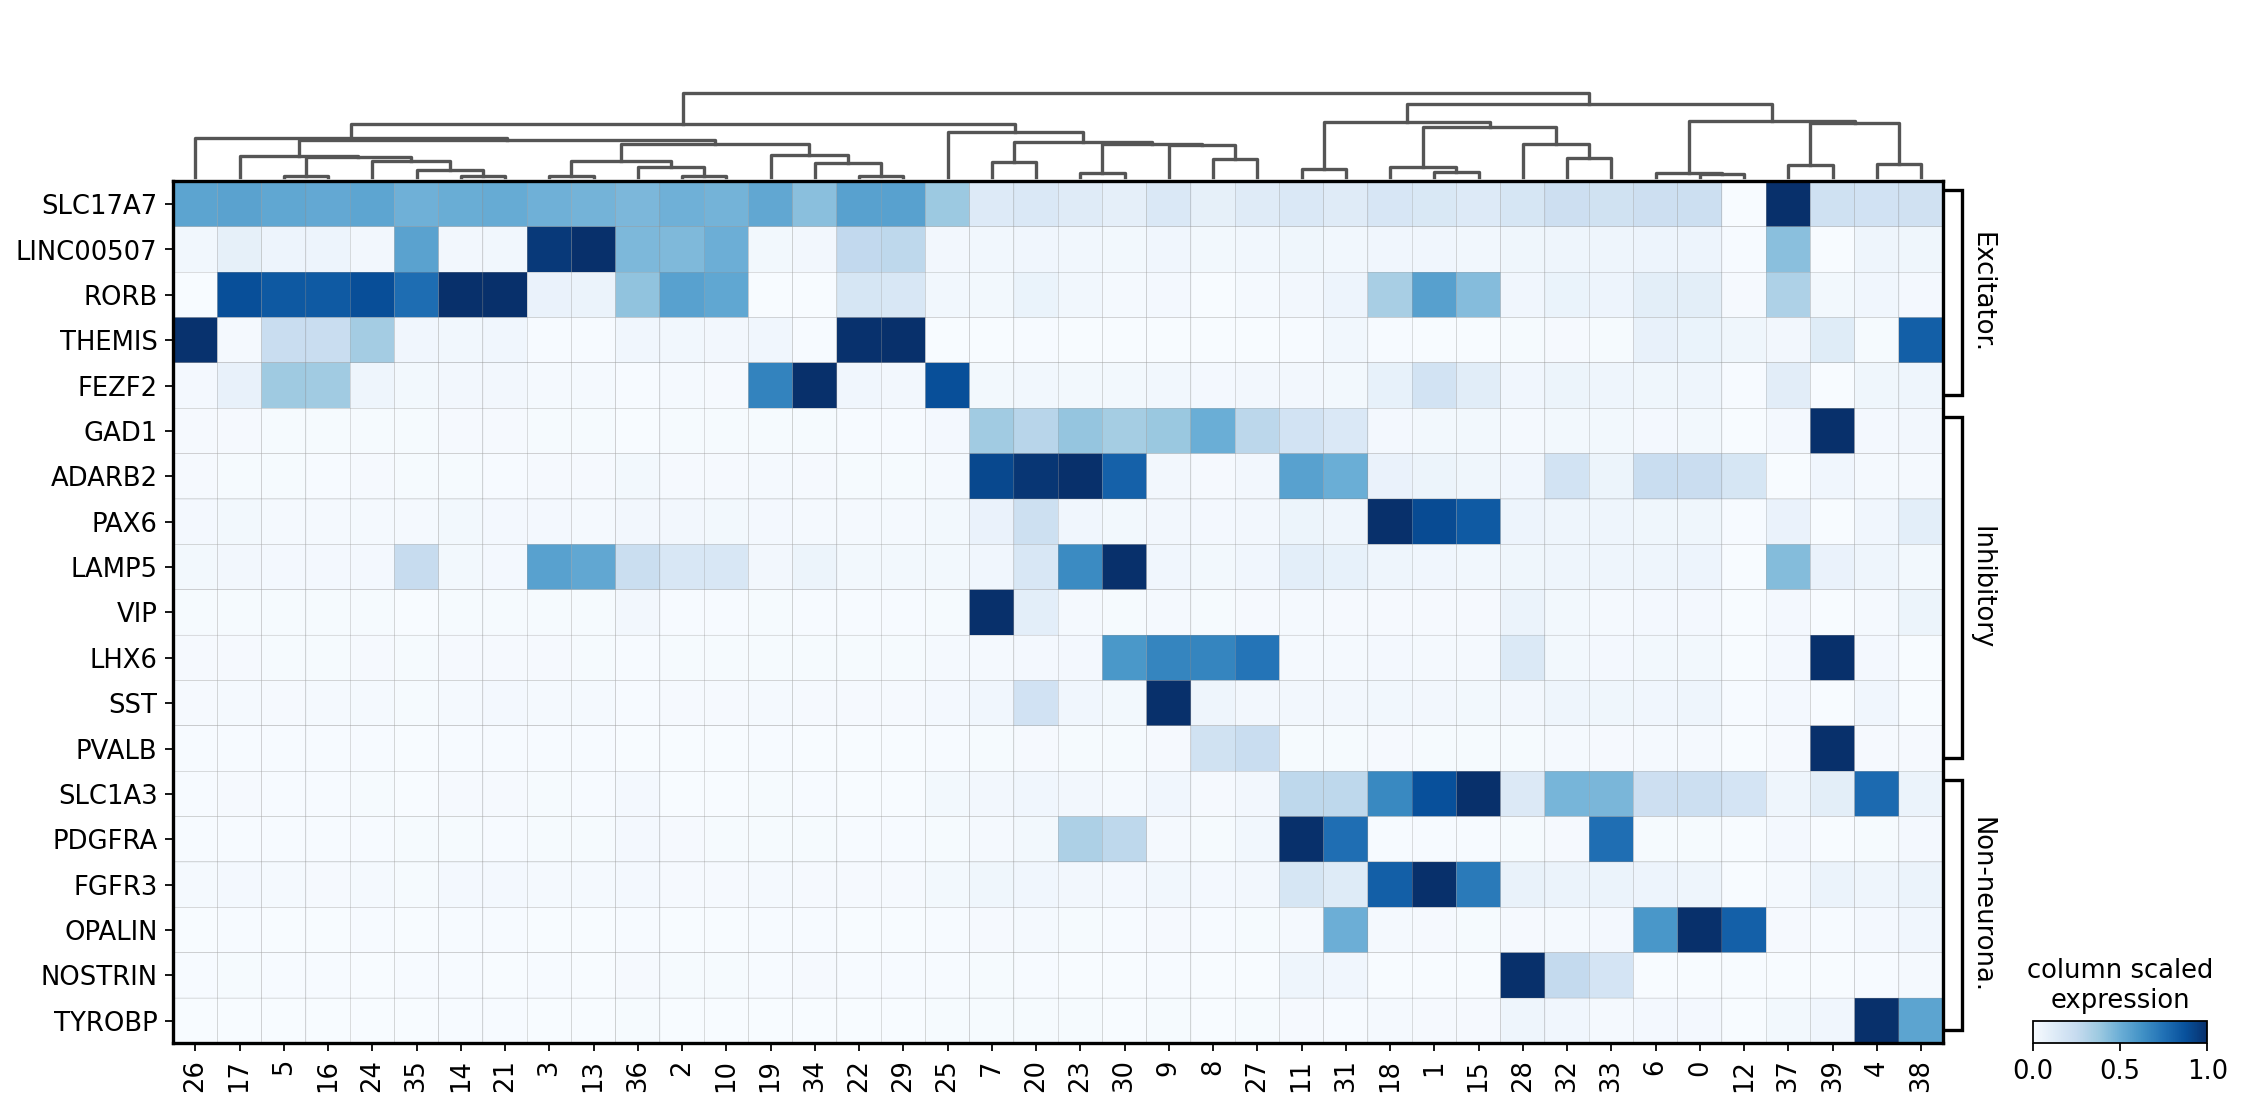

In [23]:
sc.pl.matrixplot(adata, marker_genes_dict, swap_axes = True,
                 groupby='leiden', dendrogram=True, cmap='Blues', 
                 standard_scale='var', 
                 colorbar_title='column scaled\nexpression') 

In [24]:
adata.obs.loc[adata.obs['leiden'].isin(['17', '5', '16', '24', '35', '14', '21']), 'cluster_Allen'] = 'Ext RORB'
adata.obs.loc[adata.obs['leiden'].isin(['19', '34', '25']), 'cluster_Allen'] = 'Ext FEZF2'
adata.obs.loc[adata.obs['leiden'].isin(['3', '13', '36', '2', '10']), 'cluster_Allen'] = 'Ext LINC00507'
adata.obs.loc[adata.obs['leiden'].isin(['26', '22', '29']), 'cluster_Allen'] = 'Ext THEMIS'
adata.obs.loc[adata.obs['leiden'].isin(['23', '30']), 'cluster_Allen'] = 'Inh LAMP5'
adata.obs.loc[adata.obs['leiden'].isin(['7']), 'cluster_Allen'] = 'Inh VIP'
adata.obs.loc[adata.obs['leiden'].isin(['8', '27']), 'cluster_Allen'] = 'Inh PVALB'
adata.obs.loc[adata.obs['leiden'].isin(['9', '20']), 'cluster_Allen'] = 'Inh SST'
adata.obs.loc[adata.obs['leiden'].isin(['11', '31']), 'cluster_Allen'] = 'OPC' 
adata.obs.loc[adata.obs['leiden'].isin(['18', '1', '15']), 'cluster_Allen'] = 'Astrocyte'
adata.obs.loc[adata.obs['leiden'].isin(['6', '0', '12']), 'cluster_Allen'] = 'Oligodendrocyte'
adata.obs.loc[adata.obs['leiden'].isin(['28', '32', '33']), 'cluster_Allen'] = 'Vascular'
adata.obs.loc[adata.obs['leiden'].isin(['4', '38']), 'cluster_Allen'] = 'Microglia'
adata.obs.loc[adata.obs['leiden'].isin(['37', '39']), 'cluster_Allen'] = 'Others'

In [26]:
adata.obs['cluster_Allen'] = adata.obs['cluster_Allen'].astype('category')
adata.obs['cluster_Allen'] = adata.obs['cluster_Allen'].cat.reorder_categories(['Ext LINC00507', 'Ext RORB', 'Ext THEMIS', 'Ext FEZF2', 'Inh LAMP5', 'Inh VIP', 'Inh SST', 'Inh PVALB', 'Astrocyte', 'Microglia', 'Oligodendrocyte', 'OPC', 'Vascular', 'Others'])

In [27]:
col_dict_leiden = {
    'Astrocyte': '#1663BE', # Late adult, Astro
    'Ext FEZF2': '#ff9800',
    'Ext LINC00507': '#ff7034',
    'Ext RORB': '#ffcc80',
    'Ext THEMIS': '#ffeacc',
    'Inh LAMP5': '#1E5631',
    'Inh PVALB': '#A4DE02',
    'Inh SST': '#68BB59',
    'Inh VIP': '#ACDF87',
    'Microglia': '#b042ff',
    'OPC': '#8d6e63',
    'Oligodendrocyte': '#f8bbd0',
    'Vascular': "#C30010",
    'Others': "#808080"
}

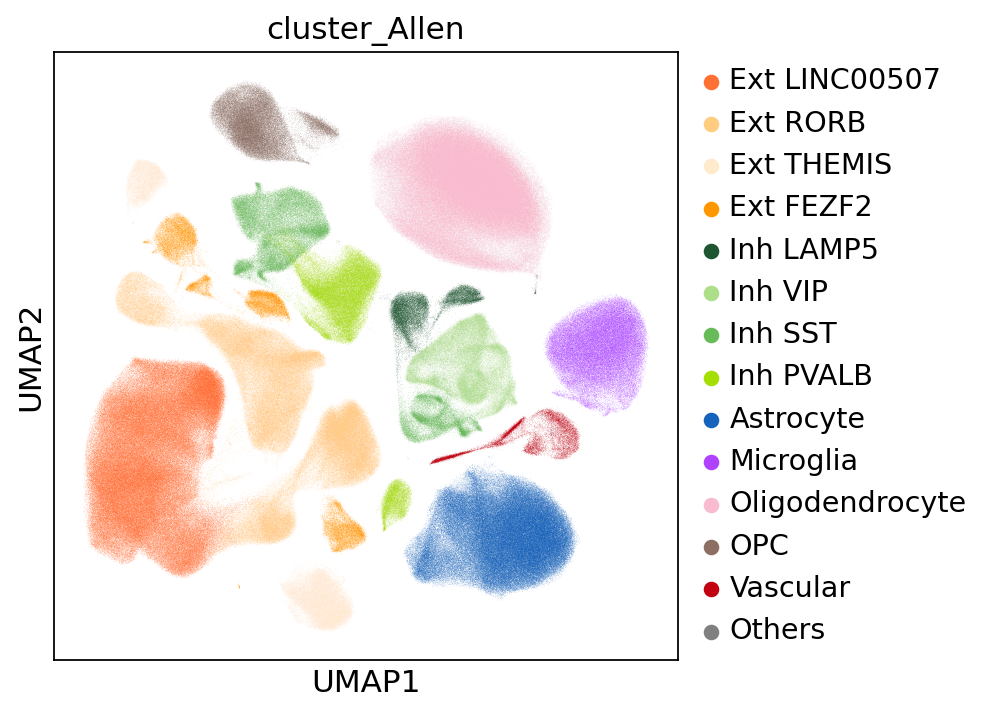

In [30]:
sc.pl.umap(adata, color = ["cluster_Allen"], palette = col_dict_leiden)

In [31]:
adata.write_h5ad("Data/ROSMAP2_Annotated.h5ad") # type: ignore

In [32]:
adata # 1560049 obs.

AnnData object with n_obs × n_vars = 1560049 × 5000
    obs: 'batch', 'sampleID', 'Age', 'Assay', 'Stage', 'Race', 'Library', 'Hemisphere', 'PMI', 'Brain_Region', 'Dataset', 'Sex', 'Diagnosis', 'cluster_original', 'cluster_main', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'batch_numeric', 'sampleID_numeric', 'cluster_Allen'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'cluster_main_colors', 'cluster_original_colors', 'leiden_colors', 'dendrogram_leiden', 'cluster_Allen_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'counts', 'logcounts', 'scaled'
    obsp: 'distances', 'connectivities'